# How to call tools

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#tools">
                    Tools
                </a>
            </li>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#chat-models/">
                    Chat Models
                </a>
            </li>
        </ul>
    </p>
</div> 

This guide covers how add tool-calling to your LangGraph application. There are two ways to do this in LangGraph:

* implement a custom tool-calling node
* use LangGraph's prebuilt [`ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/#toolnode)

In this guide we will show both of these approaches and how to use them with a LangGraph [ReAct-style](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-implementation) agent.

<div class="admonition note">
    <p class="admonition-title">Note</p>
    <p>
        You <strong>DO NOT</strong> need to use the prebuilt <code>ToolNode</code> to add tool-calling in LangGraph. While <code>ToolNode</code> is great for most use cases and provides convenience features like parallel tool invocation and error-handling, implementing your own tool-calling node gives you more flexibility to add custom application logic.
    </p>
</div> 

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

ANTHROPIC_API_KEY:  ········


<div class="admonition tip">
    <p class="admonition-title">Set up <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM graphs built with LangGraph — read more about how to get started <a href="https://docs.smith.langchain.com">here</a>. 
    </p>
</div>    

## Define tools

Let's first define our tools. We will do so by creating functions and decorating them with LangChain `@tool` [decorator](https://python.langchain.com/docs/how_to/custom_tools/#tool-decorator).

In [3]:
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["sf", "san francisco"]:
        return "It's 60 degrees and foggy."
    else:
        return "It's 90 degrees and sunny."


@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "nyc, sf"


tools = [get_weather, get_coolest_cities]

## Using a custom tool-calling node

We can now implement a LangGraph [node](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) that will call these tools. This node will be a part of the ReAct agent graph that will be using [MessagesState](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) as [state schema](https://langchain-ai.github.io/langgraph/concepts/low_level/#schema).

In the agent graph this node will be called after receiving a model response (`AIMessage`) with tool calls.

In [4]:
import json
from langgraph.graph import MessagesState


def call_tools(state: MessagesState):
    tools_by_name = {tool.name: tool for tool in tools}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        # call the tools
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        output_messages.append(
            # wrap the tool call results in a ToolMessage.
            # model providers like OpenAI and Anthropic expect any AIMessages with
            # tool calls to be followed by ToolMessages with the tool call results.
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": output_messages}

Let's try running the node function on an `AIMessage` with `tool_calls` parameter. 

In [5]:
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "get_coolest_cities",
            "args": {},
            "id": "tool_call_id_1",
            "type": "tool_call",
        },
        {
            "name": "get_weather",
            "args": {"location": "sf"},
            "id": "tool_call_id_2",
            "type": "tool_call",
        },
    ],
)

In [6]:
call_tools({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='"nyc, sf"', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content='"It\'s 60 degrees and foggy."', name='get_weather', tool_call_id='tool_call_id_2')]}

Now let's try using this function together with an actual language model.

We'll be using a small chat model from Anthropic in our example. To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. We do this by calling `.bind_tools` method on `ChatAnthropic` model.

In [7]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

In [8]:
model_with_tools.invoke("what's the weather in sf?").tool_calls

[{'name': 'get_weather',
  'args': {'location': 'San Francisco'},
  'id': 'toolu_01CG2bTZDNHJoFTMgsm5n41u',
  'type': 'tool_call'}]

As you can see, the AI message generated by the chat model already has `tool_calls` populated, so we can just pass it directly to the tool-calling function.

In [9]:
call_tools({"messages": [model_with_tools.invoke("what's the weather in sf?")]})

{'messages': [ToolMessage(content='"It\'s 60 degrees and foggy."', name='get_weather', tool_call_id='toolu_01RSceLxdFo5hNzeucwZDyV5')]}

## ReAct Agent

Next, let's see how to use our tool-calling node inside a LangGraph graph. Let's set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using tool-calling node and the Anthropic model with tools we just defined

In [10]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


builder = StateGraph(MessagesState)

# Define the two nodes we will cycle between
builder.add_node("agent", call_model)
builder.add_node("tools", call_tools)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, path_map=["tools", END])
builder.add_edge("tools", "agent")

graph = builder.compile()

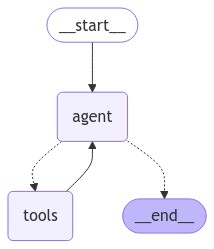

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Let's try it out!

In [12]:
# example with a single tool call
for chunk in graph.stream(
    {"messages": [("human", "what's the weather in sf?")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in sf?
================================== Ai Message ==================================

[{'text': "Okay, let's check the weather in San Francisco:", 'type': 'text'}, {'id': 'toolu_01GqVoFbj5rjJt83VsvrPtoQ', 'input': {'location': 'San Francisco'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_01GqVoFbj5rjJt83VsvrPtoQ)
 Call ID: toolu_01GqVoFbj5rjJt83VsvrPtoQ
  Args:
    location: San Francisco
================================= Tool Message =================================
Name: get_weather

"It's 60 degrees and foggy."
================================== Ai Message ==================================

The weather in San Francisco is 60 degrees and foggy.


In [13]:
# example with a multiple tool calls in succession

for chunk in graph.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================

[{'text': "Okay, let's find out the weather in the coolest cities:", 'type': 'text'}, {'id': 'toolu_01RxtwGcoquV7TRM7P8xdcvA', 'input': {}, 'name': 'get_coolest_cities', 'type': 'tool_use'}]
Tool Calls:
  get_coolest_cities (toolu_01RxtwGcoquV7TRM7P8xdcvA)
 Call ID: toolu_01RxtwGcoquV7TRM7P8xdcvA
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

"nyc, sf"
================================== Ai Message ==================================

[{'text': "Now let's get the weather for those cities:", 'type': 'text'}, {'id': 'toolu_013xxfJ5VwGS3U3wdZLNe8br', 'input': {'location': 'nyc'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_013xxfJ5VwGS3U3wdZLNe8br)
 Call ID: toolu_013xxfJ5VwGS3U3wdZLNe8br


## Using prebuilt ToolNode

Now let's try using the prebuilt `ToolNode` instead of the custom `call_tools` we just implemented.

`ToolNode` is a LangChain [Runnable](https://python.langchain.com/docs/concepts/#runnable-interface) that takes graph state (with a list of messages) as input and outputs state update with the result of tool calls. It is designed to work well out-of-box with LangGraph's prebuilt [ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/), but can also work with any `StateGraph` as long as its state has a `messages` key with an graphropriate reducer (see [`MessagesState`](https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150)).

The advantages of using `ToolNode` include:
* support for both sync and async tools
* concurrent execution of the tools
* error handling during tool execution. You can enable / disable this by setting `handle_tool_errors=True` (enabled by default). See our guide on handling errors in `ToolNode` [here](https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/)

Similar to our `call_tools` implementation, `ToolNode` expects the last message in the list to be an `AIMessage` with `tool_calls` parameter. 
Let's first see how to invoke the tool node manually:

In [14]:
tool_node = ToolNode(tools)

tool_node.invoke({"messages": [message_with_multiple_tool_calls]})

{'messages': [ToolMessage(content='nyc, sf', name='get_coolest_cities', tool_call_id='tool_call_id_1'),
  ToolMessage(content="It's 60 degrees and foggy.", name='get_weather', tool_call_id='tool_call_id_2')]}

We can now replace the tool-calling node in the above graph with the `ToolNode` one:

In [15]:
builder = StateGraph(MessagesState)

# Define the two nodes we will cycle between
builder.add_node("agent", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", should_continue, path_map=["tools", END])
builder.add_edge("tools", "agent")

graph = builder.compile()

In [ ]:
# example with a multiple tool calls in succession

for chunk in graph.stream(
    {"messages": [("human", "what's the weather in the coolest cities?")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

what's the weather in the coolest cities?
================================== Ai Message ==================================

[{'text': "Okay, let's find out the weather in the coolest cities:", 'type': 'text'}, {'id': 'toolu_01DxAWNhfMi56jxMGs5LuFL8', 'input': {}, 'name': 'get_coolest_cities', 'type': 'tool_use'}]
Tool Calls:
  get_coolest_cities (toolu_01DxAWNhfMi56jxMGs5LuFL8)
 Call ID: toolu_01DxAWNhfMi56jxMGs5LuFL8
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

nyc, sf
================================== Ai Message ==================================

[{'text': "Now let's get the weather for those cities:", 'type': 'text'}, {'id': 'toolu_018DN5UW36mu29V7mYxULexD', 'input': {'location': 'nyc'}, 'name': 'get_weather', 'type': 'tool_use'}]
Tool Calls:
  get_weather (toolu_018DN5UW36mu29V7mYxULexD)
 Call ID: toolu_018DN5UW36mu29V7mYxULexD
  